# 5.1 Criação de Modelos de Machine Learning - Tunning

## Carregar dados tratados

In [149]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [150]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.neural_network import MLPClassifier

import joblib

In [151]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [152]:
def split_dados(df, test_size: float = 0.25):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=42)

    return (X_treino, X_teste, y_treino, y_teste)

In [153]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("Precision: ", precision_score(y_teste, y_prev))
    print("#" * 50)
    return precision_score(y_teste, y_prev)


# ML modelos

## Modelos a serem testados

- Random Forest
- Gradient Boost
- AdaBoost

In [154]:
def definir_modelos_ml() -> dict:
    return {
        "RedeNeural": {'modelo_base': MLPClassifier(random_state=42), 'modelo_tunado': None},
        # "RedeNeural": {'modelo_base': MLPClassifier(random_state=42, solver='sgd', learning_rate='constant', hidden_layer_sizes=8, activation='relu'), 'modelo_tunado': None},
    }

In [155]:
def criar_modelos_ml(modelos, splited_data):
    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        X_treino, _, y_treino, _ = splited_data
        modelo.fit(X_treino, y_treino)
        modelos[nome]['modelo_base'] = modelo
    
    return modelos

# Execucao

In [156]:
def main():

    df = carregar_joblib()

    print(df.shape)

    splited_data = split_dados(df, test_size=0.15)

    modelos = definir_modelos_ml()

    modelos = criar_modelos_ml(modelos, splited_data)

    return df, modelos, splited_data

df, modelos, splited_data = main()

(1852, 6)


## Tunning do modelos

In [173]:
def fit_tunning_rand_search_nn(X_treino, y_treino):
    print("Tunning randomized search NN")
    activation = ['relu', 'logistic', 'tanh']
    activation = ['relu']
    learning_rate = ["constant", "adaptive"]
    learning_rate = ["constant"]
    solver = ['sgd', 'adam']
    solver = ['lbfgs']
    hidden_layer_sizes = [(50,50,50), (50,100,50), (100,)]

    # Create the random grid
    params = {'activation': activation,
                   'solver': solver,
                   'learning_rate': learning_rate,
                   'hidden_layer_sizes': hidden_layer_sizes,
                   'random_state': [42],
                   }

    rf_random = RandomizedSearchCV(estimator=MLPClassifier(random_state=42, max_iter=1000),
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=10,
                                   verbose=0,
                                   random_state=42,
                                   scoring="precision",
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [175]:

def run_nn_tunning(df, splited_data):

    from sklearn import preprocessing
    
    X_treino, _, y_treino, _ = splited_data
    scaler = preprocessing.StandardScaler().fit(X_treino)
    X_treino = scaler.transform(X_treino)

    # run randomized search first, then set params for grid
    resultado_grid = fit_tunning_rand_search_nn(X_treino, y_treino)

    print("Ajuste Rede neural feito")

    print("best params", resultado_grid.best_params_)
    print("best score", resultado_grid.best_score_)
    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [159]:
def compare_tunning(df, modelos: dict, splited_data):

    _, X_teste, _, y_teste = splited_data

    recalls = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        recalls[nome + '_base'] =  avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        recalls[nome + '_tunned'] = avaliar(y_teste, prev, nome + '_tunado')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
    ax.set(xlabel="Modelos", ylabel="Precision", title="Precision por Modelo")
    

In [160]:
def run_tunning_fit(df, modelos, splited_data):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['RedeNeural']['modelo_tunado'] = run_nn_tunning(df, splited_data)

    return modelos


Tunning randomized search NN


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=1000. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown

Ajuste Rede neural feito
best params {'solver': 'lbfgs', 'random_state': 42, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'activation': 'relu'}
best score 0.5056615703922116
RedeNeural_base
Reporte teste
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       135
           1       0.59      0.73      0.65       143

    accuracy                           0.60       278
   macro avg       0.60      0.59      0.59       278
weighted avg       0.60      0.60      0.59       278



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


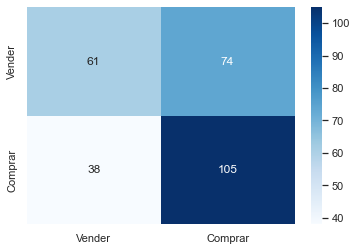

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Precision:  0.5865921787709497
##################################################
RedeNeural_tunado
Reporte teste
              precision    recall  f1-score   support

           0       0.49      0.36      0.42       135
           1       0.52      0.65      0.58       143

    accuracy                           0.51       278
   macro avg       0.51      0.51      0.50       278
weighted avg       0.51      0.51      0.50       278



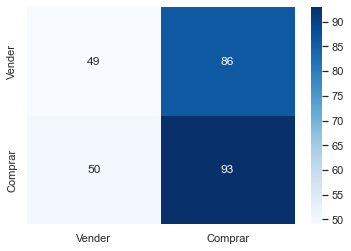

Precision:  0.5195530726256983
##################################################


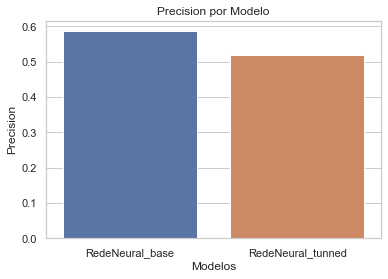

In [177]:
modelos = run_tunning_fit(df, modelos, splited_data)

compare_tunning(df, modelos, splited_data)

# Melhor modelo escolhido:

- x

Best score de x%